In [2]:
# Import necessary libraries

from dottamine import dotim
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt

In [3]:
# Load the image

image_path = 'domes/70_denoised.tif'

image = sk.io.imread(image_path)
image = np.transpose(image[3], axes=(2,0,1)) # Rotate image if necessary

In [4]:
# Create the mask of the image

dotter = dotim(image=image, is2D=False)
mask = dotter.get_mask(times=3, binshape=(2,2), v='+') # Get the mask of the image using the dottamine package

Your binning dimension and image dimension do not coincide.
Your binning dimension will be (2, 2, 2)
Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [5]:
print(mask.shape)
print(image.shape)

(858, 550, 858)
(858, 550, 858)


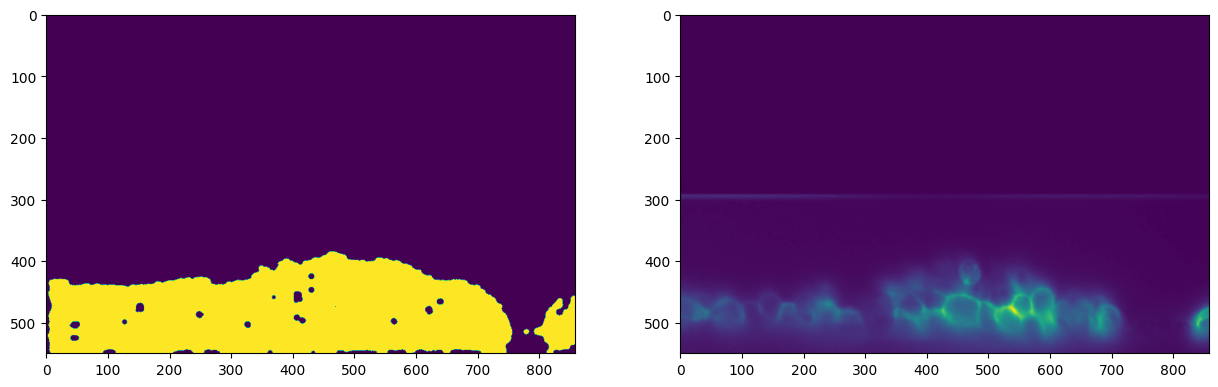

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(mask[100])
plt.subplot(122)
plt.imshow(image[100])

In [41]:
mask = mask.astype(np.uint8)
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1

def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

clean_mask = []

c = 0

for n in range(image.shape[0]):

    print(c,end='\r')
    c += 1

    height = []

    for i in range(top_mask[n].shape[1]):
        col = top_mask[n][:, i]
        height.append(np.where(col == 1)[0][0]+20) # Add a value to move the line

    height = np.array(height)
    x = np.linspace(0, 1, i+1)

    window_size = 20
    height = smooth_array(height, window_size)

    height_matrix = np.zeros((top_mask[n].shape))

    height_smooth = []
    height_smooth.append(-1)

    for i in range(height_matrix.shape[1]-1):
        if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value!
            if height[i] == 0 and height[i-1] == 0:
                height_smooth.append(-1)
                continue
            height_matrix[int(height[i])][i] = 1
            height_smooth.append(height[i])
        else:
            height_smooth.append(-1000)    


    clean_mask.append(cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[n])

clean_mask = np.array(clean_mask)

In [50]:
print(clean_mask.max())
print(clean_mask.dtype)
xmax, xmin = clean_mask.max(), clean_mask.min()
clean_mask2 = (clean_mask - xmin) / (xmax - xmin) * (2**16-1)


20.665792123995395
float64


In [53]:
clean_mask = np.uint16(clean_mask2)
im = np.uint16(image)

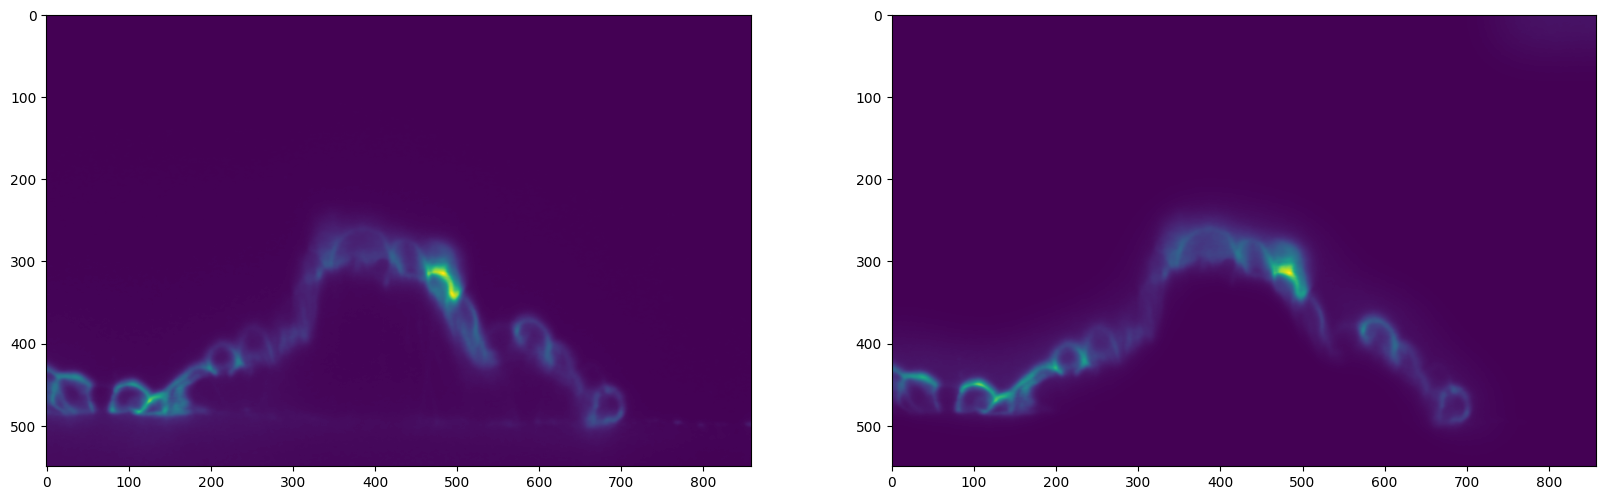

In [54]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(im[500])
plt.subplot(122)
plt.imshow(clean_mask[500])

In [57]:
import tifffile as tiff

tiff.imwrite('../ppujol/tempDomes/70_16bit_3_denoised.tif', im, imagej=True)
tiff.imwrite('../ppujol/tempDomes/70_16bit_3_denoised_cleaned.tif', clean_mask, imagej=True)

: 